In [51]:
import pandas as pd
import spacy
from time import time
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import community as community_louvain
from operator import itemgetter
import numpy as np
from itertools import combinations

In [52]:
def parse_ris_file(filename):
    records = []
    current_record = {}

    with open(filename, 'r', encoding="utf8") as file:
        for line in file:
            line = line.strip()
            if line.startswith('AU  -'):  # Author
                if 'First Author' not in current_record:
                    current_record['First Author'] = line[6:].strip()
            elif line.startswith('PY  -'):  # Publication Year
                current_record['Year'] = line[6:].strip().split('/')[0]  # Assuming format 'YYYY/MM/DD/'
            elif line.startswith('AB  -'):  # Abstract
                current_record['Abstract'] = line[6:].strip()
            elif line.startswith('DO  -'):  # DOI
                current_record['DOI'] = line[6:].strip()
            elif line == 'ER  -':  # End of record
                records.append(current_record)
                current_record = {}

    return pd.DataFrame(records)

# Replace 'path_to_your_ris_file.ris' with the path to your RIS file
df = parse_ris_file('velophary_endnote_library.txt')
df


,First Author,Year,DOI,Abstract
0,"Lang, B. R.",1969,NaN,NaN
1,"Aramany, M. A.",1970,10.1016/0022-3913(70)90027-2,NaN
2,"Marsh, J. L.",1980,10.1097/00006534-198005000-00009,Thirty-nine children with moderate-to-severe v...
3,"Yoshida, H.",1990,10.1111/j.1365-2842.1990.tb01427.x,To evaluate speech following prosthetic obtura...
4,"Dixon-Wood, V. L.",1991,10.1597/1545-1569_1991_028_0285_taosrf_2.3.co_2,This retrospective study describes the frequen...
...,...,...,...,...
70,"Tezuka, M.",2020,10.1016/j.ajoms.2020.07.010,Oropharyngeal reconstruction represents one of...
71,"Artopoulou, II",2021,10.1016/j.prosdent.2021.04.009,STATEMENT OF PROBLEM: Tumors of the soft palat...
72,"Kang, D. C.",2021,10.1186/s40902-021-00315-5,Background: Velopharyngeal incompetence (VPI) ...
73,"Nomoto, A.",2021,10.2186/jpr.JPR_D_20_00128,Patient Palatal lift prostheses (PLPs) are use...


In [53]:
nlp = spacy.load('en_core_web_sm')


In [54]:
def tokenize_abstract(abstract):
    if not isinstance(abstract, str):  # Check if the abstract is not a string
        return []  # Return an empty list or any other placeholder you prefer

    removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
    banned = ["et", "al", "et al", "etc", "figure", "fig", "table", "mm", "nm", "cm", "datum"]
    
    doc = nlp(abstract)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ not in removal
        and not token.is_stop and token.is_alpha
    ]
    filtered_tokens = [token for token in tokens if len(token) >= 3]
    banned_tokens_removed = [token for token in filtered_tokens if token not in banned]
    
    return banned_tokens_removed


In [55]:
t0 = time()

# Apply the tokenization function to each abstract
df['Tokenized Abstract'] = df['Abstract'].apply(tokenize_abstract)

print(f"Tokenization completed in {time() - t0} seconds.")
print(df.head())  # Print the first few rows to verify


Tokenization completed in 1.616692304611206 seconds.
        First Author  Year                                              DOI  \
0        Lang, B. R.  1969                                              NaN   
1     Aramany, M. A.  1970                     10.1016/0022-3913(70)90027-2   
2       Marsh, J. L.  1980                 10.1097/00006534-198005000-00009   
3        Yoshida, H.  1990               10.1111/j.1365-2842.1990.tb01427.x   
4  Dixon-Wood, V. L.  1991  10.1597/1545-1569_1991_028_0285_taosrf_2.3.co_2   

                                            Abstract  \
0                                                NaN   
1                                                NaN   
2  Thirty-nine children with moderate-to-severe v...   
3  To evaluate speech following prosthetic obtura...   
4  This retrospective study describes the frequen...   

                                  Tokenized Abstract  
0                                                 []  
1                        

In [56]:
def update_cooccurrences(cooccurrences, word_list, window_size):
    for i in range(len(word_list)):
        window_words = word_list[i:i+window_size]
        main_word = word_list[i]
        for other_word in window_words:
            if main_word != other_word:
                cooccurrences[main_word].setdefault(other_word, 0)
                cooccurrences[main_word][other_word] += 1

In [57]:
def create_cooccurrence_matrix(tokens_column, window_size):
    cooccurrences = defaultdict(dict)
    for tokens in tokens_column:
        update_cooccurrences(cooccurrences, tokens, window_size)
    return cooccurrences

In [58]:
cooccurrence_matrix = create_cooccurrence_matrix(df["Tokenized Abstract"], 5)

In [59]:
G = nx.Graph()
for word, neighbors in cooccurrence_matrix.items():
    for neighbor, weight in neighbors.items():
        G.add_edge(word, neighbor, weight=weight)

In [62]:
from importlib import reload
reload(community_louvain)

<module 'community' from 'C:\\Users\\Administrator\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\community\\__init__.py'>

In [63]:
partition = community_louvain.best_partition(G)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27192\482434677.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


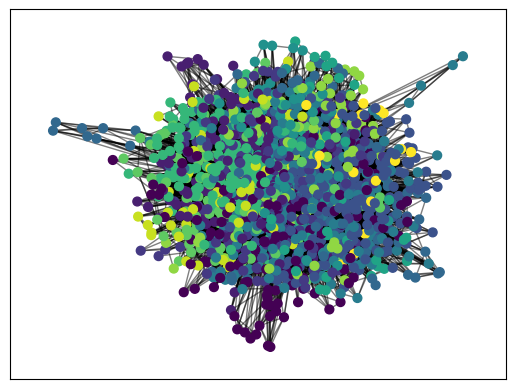

In [64]:
pos = nx.spring_layout(G) 
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [65]:
degree_centrality = nx.degree_centrality(G)


community_nodes = {}
for node, community_id in partition.items():
    if community_id not in community_nodes:
        community_nodes[community_id] = []
    community_nodes[community_id].append(node)


top_nodes_per_community = {}
for community_id, nodes in community_nodes.items():
    sorted_nodes = sorted(nodes, key=lambda n: degree_centrality[n], reverse=True)
    top_nodes_per_community[community_id] = sorted_nodes[:3]

print("Top 3 Nodes in Each Community:", top_nodes_per_community)


Top 3 Nodes in Each Community: {0: ['patient', 'cleft', 'year'], 1: ['speech', 'function', 'intelligibility'], 2: ['velopharyngeal', 'treatment', 'surgical'], 3: ['palate', 'soft', 'defect'], 4: ['method', 'new', 'technique'], 5: ['prosthesis', 'palatal', 'obturator'], 6: ['plp', 'improve', 'conclusion'], 9: ['study', 'appliance', 'outcome'], 8: ['result', 'score', 'significant'], 10: ['case', 'report', 'nasal'], 11: ['life', 'quality', 'relate'], 12: ['closure', 'height', 'image'], 7: ['language', 'prosthodontist', 'maxillofacial']}


In [66]:
word_years = defaultdict(list)
for _, row in df.iterrows():
    year = row['Year']
    for word in row['Tokenized Abstract']:
        word_years[word].append(year)

In [67]:
# Convert the 'Year' column to numeric, coercing any non-numeric values to NaN, then drop these rows
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df.dropna(subset=['Year'], inplace=True)

# Ensure that the 'Year' is in integer format
df['Year'] = df['Year'].astype(int)

# Rebuild the word_years dictionary with updated DataFrame
word_years = defaultdict(list)
for _, row in df.iterrows():
    year = row['Year']
    for word in row['Tokenized Abstract']:
        word_years[word].append(year)


In [68]:
def calculate_novelty_indicators(G, partition, word_years):
    # Inverting the partition to get a dictionary of cluster_id -> list of words
    inverted_partition = {}
    for word, cluster_id in partition.items():
        if cluster_id not in inverted_partition:
            inverted_partition[cluster_id] = []
        inverted_partition[cluster_id].append(word)

    # Flatten all years into a single list and calculate the overall network average
    all_years = [year for years in word_years.values() if isinstance(years, list) for year in years]
    network_avg = np.mean(all_years)

    # Calculate novelty indicators for each cluster
    novelty_indicators = {}
    for cluster_id, cluster_members in inverted_partition.items():
        cluster_years = [year for word in cluster_members if word in word_years for year in word_years[word]]
        if cluster_years:
            cluster_avg = np.mean(cluster_years)
            novelty_indicator = cluster_avg - network_avg
            novelty_indicators[cluster_id] = novelty_indicator
        else:
            novelty_indicators[cluster_id] = None

    return novelty_indicators


In [69]:
def calculate_attention_indicators(G, partition, cooccurrence_matrix):
    # Inverting the partition to get a dictionary of cluster_id -> list of words
    inverted_partition = {}
    for word, cluster_id in partition.items():
        if cluster_id not in inverted_partition:
            inverted_partition[cluster_id] = []
        inverted_partition[cluster_id].append(word)

    # Calculate average co-occurrence frequency for each keyword
    avg_cooccurrence_freq = {}
    for word, neighbors in cooccurrence_matrix.items():
        total_freq = sum(neighbors.values())
        avg_freq = total_freq / len(neighbors) if neighbors else 0
        avg_cooccurrence_freq[word] = avg_freq

    # Calculate overall network average
    all_frequencies = list(avg_cooccurrence_freq.values())
    network_avg = np.mean(all_frequencies)

    # Calculate attention indicators for each cluster
    attention_indicators = {}
    for cluster_id, cluster_members in inverted_partition.items():
        cluster_frequencies = [avg_cooccurrence_freq[word] for word in cluster_members if word in avg_cooccurrence_freq]
        if cluster_frequencies:
            cluster_avg = np.mean(cluster_frequencies)
            attention_indicator = cluster_avg - network_avg
            attention_indicators[cluster_id] = attention_indicator
        else:
            attention_indicators[cluster_id] = None

    return attention_indicators


In [70]:
novelty_indicators = calculate_novelty_indicators(G, partition, word_years)
attention_indicators = calculate_attention_indicators(G, partition, cooccurrence_matrix)
print("Novelty Indicators:", novelty_indicators)
print("Attention Indicators:", attention_indicators)

Novelty Indicators: {0: 0.6233101008017456, 1: -1.0966819342440886, 2: -1.5528008363176014, 3: -0.21908922451984836, 4: -0.19717756369345807, 5: -0.6995934152257632, 6: 2.725146165878641, 9: -1.556764238770711, 8: 0.6826557367603527, 10: 2.4253503544548494, 11: 5.368387056315214, 12: 0.37721058572697075, 7: 0.18603411513868195}
Attention Indicators: {0: -0.008354551295276957, 1: -0.008520904103468174, 2: 0.03516785855495286, 3: 0.012248312999349364, 4: -0.025912243817042935, 5: -0.017042523060676107, 6: 0.04183935090736646, 9: -0.0157953085006306, 8: 0.051728564477636185, 10: -0.051384640852572216, 11: -0.05244379132261767, 12: -0.01143943398726499, 7: -0.09130711601284158}


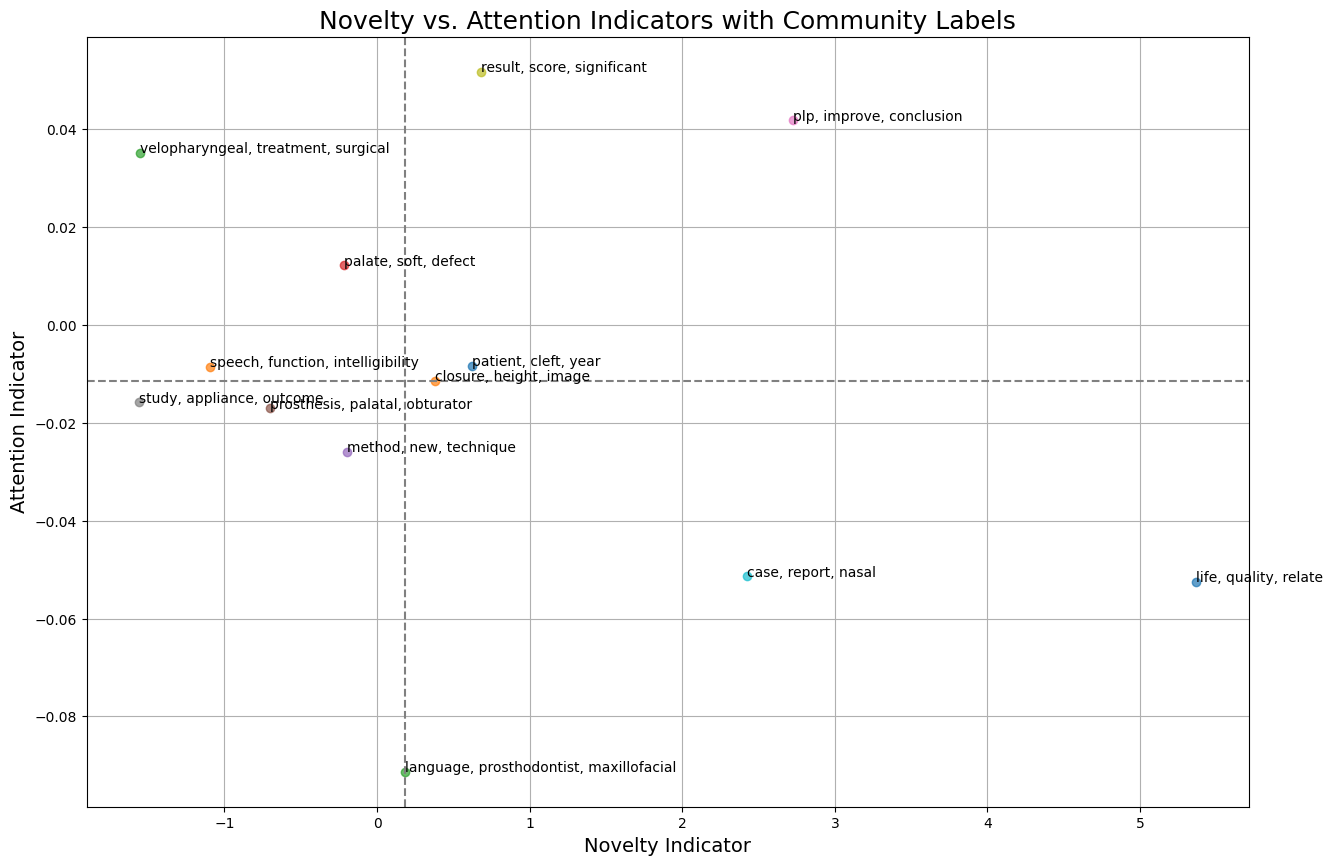

In [71]:


# Assuming you have already computed top_nodes_per_community, novelty_indicators, and attention_indicators

# Prepare labels for each community
community_labels = {community: ', '.join(top_nodes_per_community[community]) for community in top_nodes_per_community}

# Prepare the data for plotting
novelty_values = list(novelty_indicators.values())
attention_values = [attention_indicators[community] for community in novelty_indicators.keys() if community in attention_indicators]

# Filter out None values and prepare labels
valid_indices = [i for i, v in enumerate(novelty_values) if v is not None and attention_values[i] is not None]
novelty_values = [novelty_values[i] for i in valid_indices]
attention_values = [attention_values[i] for i in valid_indices]
labels = [community_labels[community] for community in novelty_indicators.keys() if community in attention_indicators and community in community_labels]

# Calculate medians
median_novelty = np.median(novelty_values)
median_attention = np.median(attention_values)

# Create the plot with larger size
plt.figure(figsize=(15, 10))  # Increased figure size
for i, label in enumerate(labels):
    plt.scatter(novelty_values[i], attention_values[i], alpha=0.7)
    plt.text(novelty_values[i], attention_values[i], label, fontsize=10)  # Increased font size for labels

# Draw lines for medians
plt.axvline(x=median_novelty, color='grey', linestyle='--')
plt.axhline(y=median_attention, color='grey', linestyle='--')

plt.xlabel('Novelty Indicator', fontsize=14)
plt.ylabel('Attention Indicator', fontsize=14)
plt.title('Novelty vs. Attention Indicators with Community Labels', fontsize=18)
plt.grid(True)
plt.show()


# Abstracts: Sentiment analysis

In [74]:
from nltk.tokenize import sent_tokenize
import transformers
from transformers import pipeline
from transformers import AutoTokenizer

model_name = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/540M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [76]:
synonyms = ["prosthesis", "prosthetics", "palatal lift prosthesis", "obturator", "prosthesis", "prosthetic appliance", "dental prosthesis", "maxillofacial prosthesis", "speech-aid", "palatal obturator", "nasal obturator", "speech bulb", "appliance"]

In [81]:
def import_sentences(abstract):
    # Check if the abstract is a string
    if not isinstance(abstract, str):
        return []  # Return an empty list for non-string abstracts

    sentences = sent_tokenize(abstract)
    filtered_sentences = [sentence for sentence in sentences if any(term in sentence.lower() for term in synonyms)]
    return filtered_sentences


In [82]:
df['Filtered_Sentences'] = df['Abstract'].apply(import_sentences)


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Administrator/nltk_data'
    - 'C:\\Users\\Administrator\\AppData\\Local\\Programs\\Python\\Python312\\nltk_data'
    - 'C:\\Users\\Administrator\\AppData\\Local\\Programs\\Python\\Python312\\share\\nltk_data'
    - 'C:\\Users\\Administrator\\AppData\\Local\\Programs\\Python\\Python312\\lib\\nltk_data'
    - 'C:\\Users\\Administrator\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [79]:
def analyze_sentiment(sentences):
    sentiments = []
    for sentence in sentences:
        # Ensure the sentence is a string
        if isinstance(sentence, str):
            # Split long sentences into chunks
            words = sentence.split()
            max_length = 50  # Adjust as needed
            chunks = [' '.join(words[i:i + max_length]) for i in range(0, len(words), max_length)]
            
            for chunk in chunks:
                try:
                    # Analyze sentiment of each chunk individually
                    result = sentiment_pipeline(chunk)
                    sentiments.append(result)
                except Exception as e:
                    print(f"Error processing chunk: {chunk}\n{e}")
    # Flatten the list of lists into a single list
    flattened_sentiments = [item for sublist in sentiments for item in sublist]
    return flattened_sentiments

In [80]:
df['Sentiment'] = df['Filtered_Sentences'].apply(analyze_sentiment)


KeyError: 'Filtered_Sentences'

In [ ]:
df

### Now, the sentiment counts should be aggregated

In each row (abstract), the sentiment of the filtered sentences should be aggregated. For example: 2 sentences are negative, 1 is neutral.

In [28]:
sentiment_counts = {'Author_Year': [], 'Year': [], 'Negative': [], 'Neutral': [], 'Positive': []}

for (author, year), group in df.groupby(['First Author', 'Year']):
    neg, neu, pos = 0, 0, 0
    for sentiments in group['Sentiment']:
        for sentiment in sentiments:
            if sentiment['label'] == 'NEG':
                neg += 1
            elif sentiment['label'] == 'NEU':
                neu += 1
            elif sentiment['label'] == 'POS':
                pos += 1
    if neg + neu + pos > 0:
        author_year_label = f"{author} ({year})"
        sentiment_counts['Author_Year'].append(author_year_label)
        sentiment_counts['Year'].append(year)
        sentiment_counts['Negative'].append(neg)
        sentiment_counts['Neutral'].append(neu)
        sentiment_counts['Positive'].append(pos)

In [29]:
plot_data = pd.DataFrame(sentiment_counts)
plot_data

,Author_Year,Year,Negative,Neutral,Positive
0,"Aboloyoun, A. I. (2013)",2013,0,2,2
1,"Ahmad, M. (2013)",2013,0,2,0
2,"Alfwaress, F. S. D. (2017)",2017,0,1,0
3,"Artopoulou, II (2005)",2005,0,0,1
4,"Artopoulou, II (2021)",2021,0,6,2
...,...,...,...,...,...
58,"Witt, P. D. (1995)",1995,0,4,0
59,"Yoshida, H. (1990)",1990,1,1,1
60,"Yoshida, H. (1993)",1993,0,2,2
61,"You, P. (2018)",2018,0,1,0


### Data is sorted by 'Year'

In [30]:
plot_data_sorted = plot_data.sort_values(by='Year')
plot_data_sorted

,Author_Year,Year,Negative,Neutral,Positive
26,"Marsh, J. L. (1980)",1980,0,1,0
59,"Yoshida, H. (1990)",1990,1,1,1
15,"Harrison, J. W. (1992)",1992,1,1,0
27,"Matsui, Y. (1993)",1993,0,1,0
60,"Yoshida, H. (1993)",1993,0,2,2
...,...,...,...,...,...
36,"Pegoraro-Krook, M. I. (2020)",2020,0,5,2
30,"Nomoto, A. N. (2020)",2020,0,1,0
56,"Wadud, A. (2021)",2021,0,2,0
18,"Kang, D. C. (2021)",2021,0,2,0


### Plotting the data in a stacked bar chart

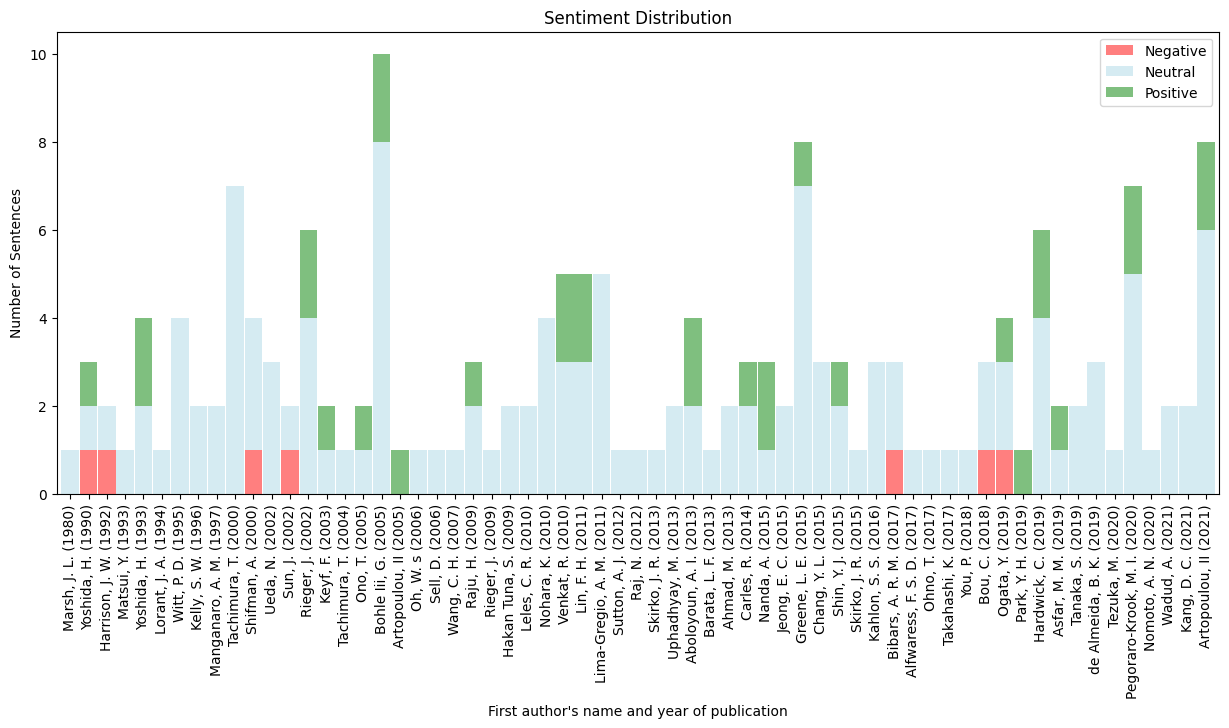

In [31]:
plot_data_for_plotting = plot_data_sorted.drop(columns=['Year'])

# Set the index to 'Author_Year' for the plot
plot_data_for_plotting.set_index('Author_Year').plot(
    kind='bar', 
    stacked=True, 
    color=['red', 'lightblue', 'green'],  # colors for 'negative', 'neutral', 'positive'
    figsize=(15, 6),
    width=0.95,
    alpha=0.5
)

plt.title('Sentiment Distribution')
plt.xlabel("First author's name and year of publication")
plt.ylabel('Number of Sentences')
plt.show()


## Weighted labels with scores

In [32]:
sentiment_counts_weighted = {'Author_Year': [], 'Year': [], 'Negative': [], 'Neutral': [], 'Positive': []}

for (author, year), group in df.groupby(['First Author', 'Year']):
    neg_score, neu_score, pos_score = 0.0, 0.0, 0.0
    for sentiments in group['Sentiment']:
        for sentiment in sentiments:
            score = float(sentiment['score'])
            if sentiment['label'] == 'NEGA':
                neg_score += score
            elif sentiment['label'] == 'NEU':
                neu_score += score
            elif sentiment['label'] == 'POS':
                pos_score += score
    if neg_score + neu_score + pos_score > 0:
        author_year_label = f"{author} ({year})"
        sentiment_counts['Author_Year'].append(author_year_label)
        sentiment_counts['Year'].append(year)
        sentiment_counts['Negative'].append(neg_score)
        sentiment_counts['Neutral'].append(neu_score)
        sentiment_counts['Positive'].append(pos_score)

plot_data = pd.DataFrame(sentiment_counts)
plot_data

,Author_Year,Year,Negative,Neutral,Positive
0,"Aboloyoun, A. I. (2013)",2013,0.0,2.000000,2.000000
1,"Ahmad, M. (2013)",2013,0.0,2.000000,0.000000
2,"Alfwaress, F. S. D. (2017)",2017,0.0,1.000000,0.000000
3,"Artopoulou, II (2005)",2005,0.0,0.000000,1.000000
4,"Artopoulou, II (2021)",2021,0.0,6.000000,2.000000
...,...,...,...,...,...
121,"Witt, P. D. (1995)",1995,0.0,3.362562,0.000000
122,"Yoshida, H. (1990)",1990,0.0,0.695671,0.541508
123,"Yoshida, H. (1993)",1993,0.0,1.930863,1.858571
124,"You, P. (2018)",2018,0.0,0.952572,0.000000


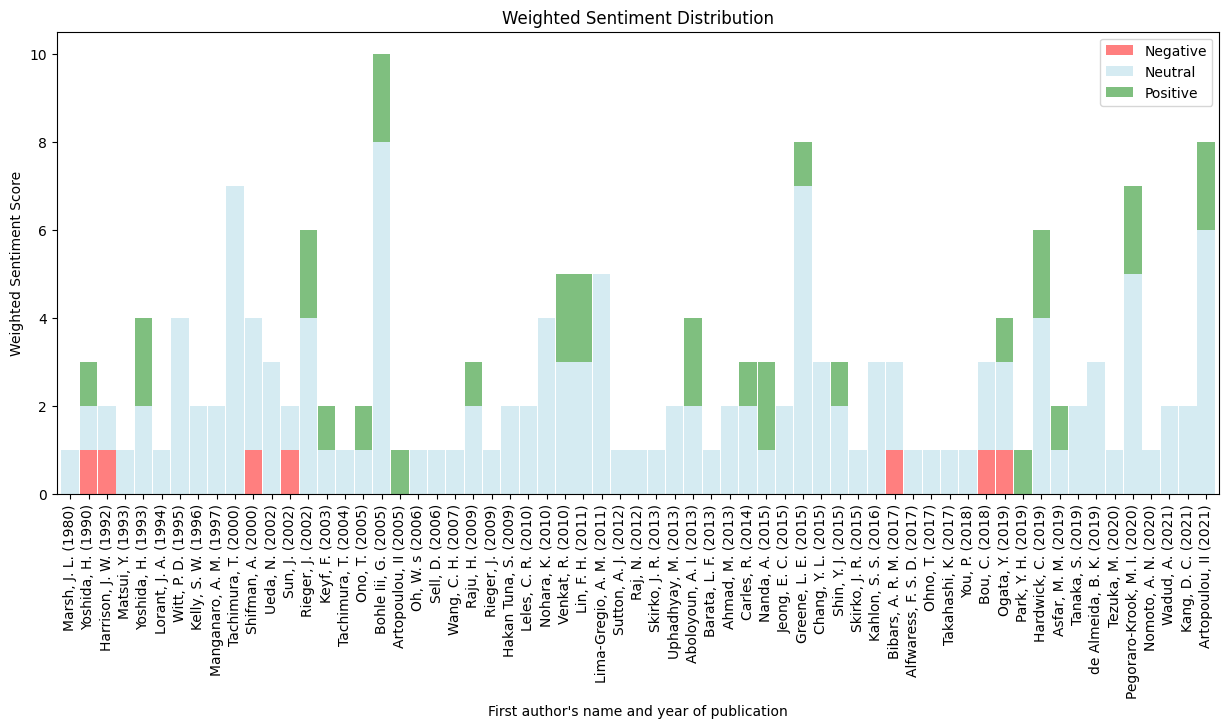

In [33]:
plot_data_for_plotting = plot_data_sorted.drop(columns=['Year'])

plot_data_for_plotting.set_index('Author_Year').plot(
    kind='bar', 
    stacked=True, 
    color={'Negative': 'red', 'Neutral': 'lightblue', 'Positive': 'green'},  # Ensure these match your DataFrame's column names
    figsize=(15, 6),
    width=0.95,
    alpha=0.5
)

plt.title('Weighted Sentiment Distribution')
plt.xlabel("First author's name and year of publication")
plt.ylabel('Weighted Sentiment Score')
plt.show()


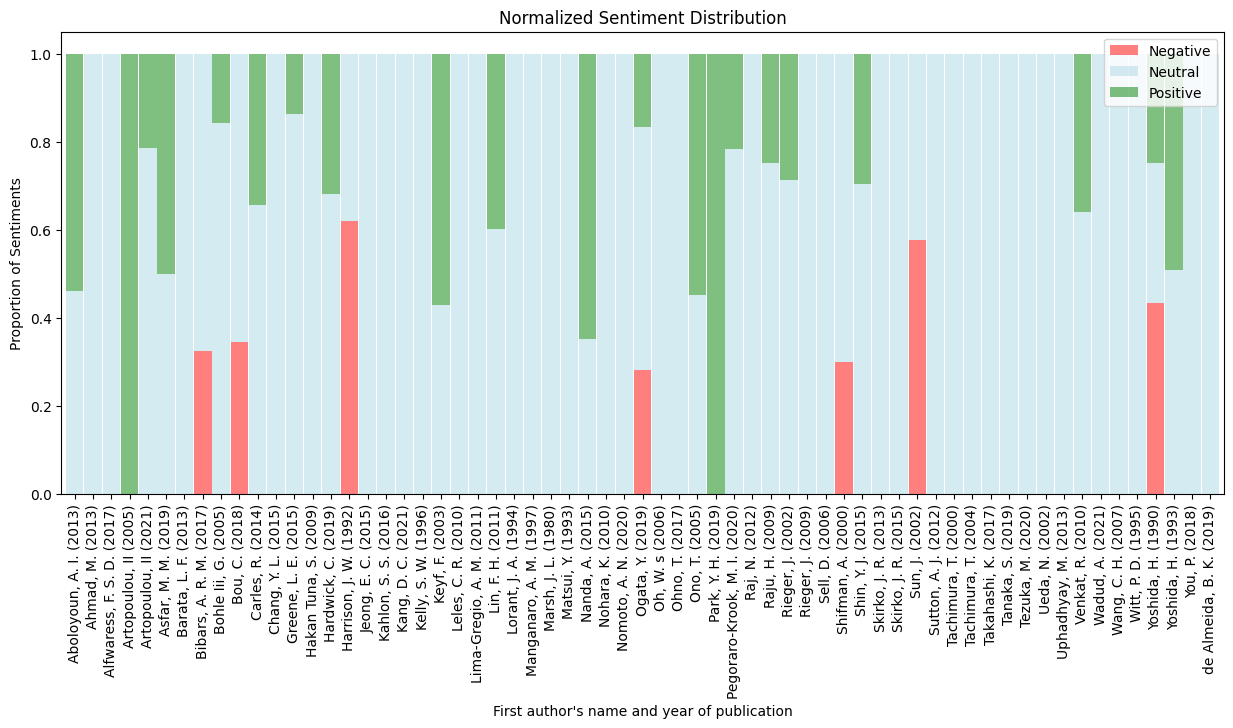

In [35]:
sentiment_counts_weighted = {'Author_Year': [], 'Year': [], 'Negative': [], 'Neutral': [], 'Positive': []}

for (author, year), group in df.groupby(['First Author', 'Year']):
    neg_score, neu_score, pos_score = 0.0, 0.0, 0.0
    for sentiments in group['Sentiment']:
        for sentiment in sentiments:
            score = float(sentiment['score'])
            if sentiment['label'] == 'NEG':
                neg_score += score
            elif sentiment['label'] == 'NEU':
                neu_score += score
            elif sentiment['label'] == 'POS':
                pos_score += score
    
    total_score = neg_score + neu_score + pos_score
    if total_score > 0:
        neg_proportion = neg_score / total_score
        neu_proportion = neu_score / total_score
        pos_proportion = pos_score / total_score

        author_year_label = f"{author} ({year})"
        sentiment_counts_weighted['Author_Year'].append(author_year_label)
        sentiment_counts_weighted['Year'].append(year)
        sentiment_counts_weighted['Negative'].append(neg_proportion)
        sentiment_counts_weighted['Neutral'].append(neu_proportion)
        sentiment_counts_weighted['Positive'].append(pos_proportion)

plot_data = pd.DataFrame(sentiment_counts_weighted)
plot_data_for_plotting = plot_data.drop(columns=['Year'])

plot_data_for_plotting.set_index('Author_Year').plot(
    kind='bar', 
    stacked=True, 
    color={'Negative': 'red', 'Neutral': 'lightblue', 'Positive': 'green'},  # Ensure these match your DataFrame's column names
    figsize=(15, 6),
    width=0.95,
    alpha=0.5
)

plt.title('Normalized Sentiment Distribution')
plt.xlabel("First author's name and year of publication")
plt.ylabel('Proportion of Sentiments')
plt.show()


## Weighted sentiment distribution by YEARS

In [32]:
# Initialize counts
yearly_sentiment_counts = {'Year': [], 'Negative': [], 'Neutral': [], 'Positive': []}

# Aggregate weighted sentiment scores by year, omitting years with no data
for year, group in df.groupby('Year'):
    neg_score, neu_score, pos_score = 0.0, 0.0, 0.0
    for sentiments in group['Sentiment']:
        for sentiment in sentiments:
            score = float(sentiment['score'])
            if sentiment['label'] == 'NEG':
                neg_score += score
            elif sentiment['label'] == 'NEU':
                neu_score += score
            elif sentiment['label'] == 'POS':
                pos_score += score
    total_score = neg_score + neu_score + pos_score
    if total_score > 0:  # Only include years with data
        yearly_sentiment_counts['Year'].append(year)
        yearly_sentiment_counts['Negative'].append(neg_score)
        yearly_sentiment_counts['Neutral'].append(neu_score)
        yearly_sentiment_counts['Positive'].append(pos_score)

# Convert to DataFrame for plotting
yearly_plot_data = pd.DataFrame(yearly_sentiment_counts)


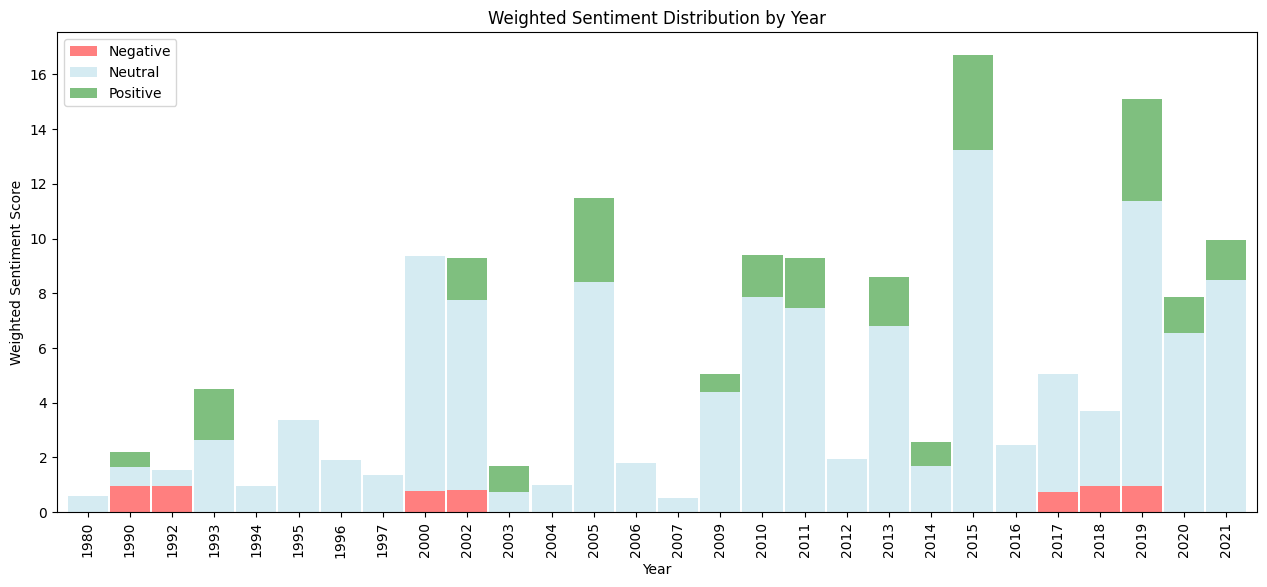

In [33]:
# Sort the DataFrame by Year
yearly_plot_data_sorted = yearly_plot_data.sort_values(by='Year')

# Plot the weighted sentiment data by year
yearly_plot_data_sorted.set_index('Year').plot(
    kind='bar', 
    stacked=True, 
    color={'Negative': 'red', 'Neutral': 'lightblue', 'Positive': 'green'}, 
    figsize=(15, 6),
    width=0.95,
    alpha=0.5)
plt.title('Weighted Sentiment Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Weighted Sentiment Score')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()


# Cumulative counts of studies in the topic

In [50]:
df

,First Author,Year,Abstract,Tokenized Abstract,Filtered_Sentences,Sentiment
0,"Lang, B. R.",1969,NaN,[],[],[]
1,"Aramany, M. A.",1970,NaN,[],[],[]
2,"Marsh, J. L.",1980,Thirty-nine children with moderate-to-severe v...,"[child, moderate, severe, velopharyngeal, inco...","[The prosthetic speech appliance, when obtaine...","[{'label': 'NEU', 'score': 0.5782287120819092}]"
3,"Yoshida, H.",1990,To evaluate speech following prosthetic obtura...,"[evaluate, speech, follow, prosthetic, obturat...",[Following placement of maxillary obturator pr...,"[{'label': 'NEU', 'score': 0.6956709623336792}..."
4,"Dixon-Wood, V. L.",1991,This retrospective study describes the frequen...,"[retrospective, study, describe, frequency, te...",[],[]
...,...,...,...,...,...,...
70,"Tezuka, M.",2020,Oropharyngeal reconstruction represents one of...,"[oropharyngeal, reconstruction, represent, gre...",[Repair involved soft palate reconstruction by...,"[{'label': 'NEU', 'score': 0.9687171578407288}]"
71,"Artopoulou, II",2021,STATEMENT OF PROBLEM: Tumors of the soft palat...,"[statement, problem, tumor, soft, palate, adja...",[Soft palate obturator prostheses can usually ...,"[{'label': 'NEU', 'score': 0.8361769914627075}..."
72,"Kang, D. C.",2021,Background: Velopharyngeal incompetence (VPI) ...,"[background, velopharyngeal, incompetence, vpi...","[Herein, we present a case of an adult with ar...","[{'label': 'NEU', 'score': 0.9497508406639099}..."
73,"Nomoto, A.",2021,Patient Palatal lift prostheses (PLPs) are use...,"[patient, palatal, lift, prosthesis, plp, dysa...",[],[]


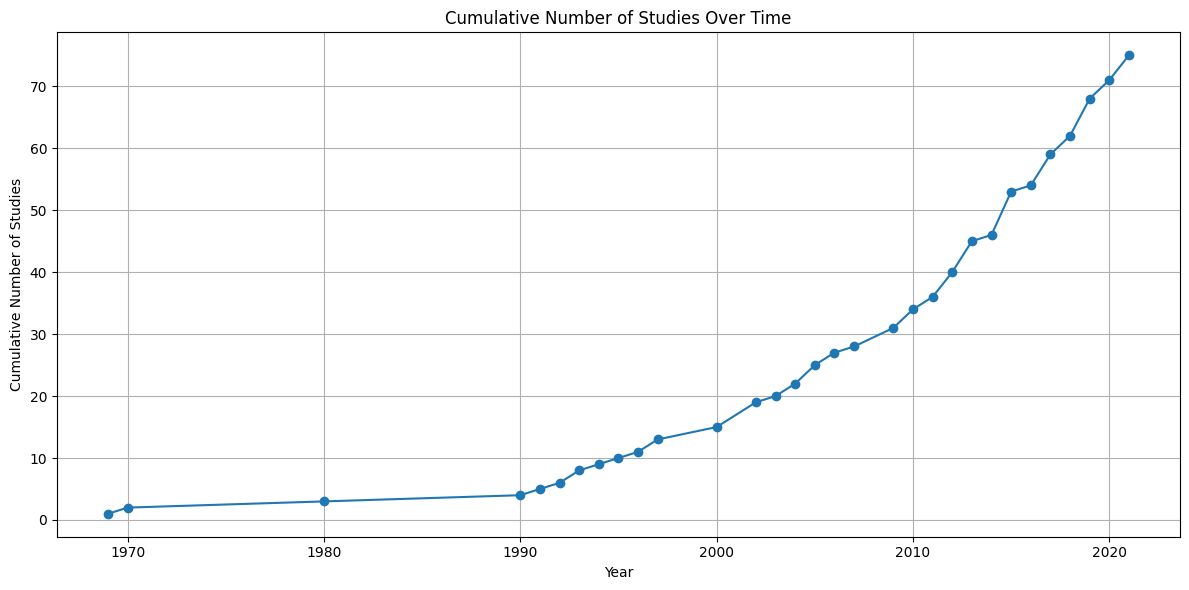

In [51]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Drop rows with NaN values in 'Year' column that could have appeared due to conversion
df = df.dropna(subset=['Year'])

# Convert 'Year' to integer
df['Year'] = df['Year'].astype(int)

# Count the number of studies per year
studies_per_year = df['Year'].value_counts().sort_index()

# Calculate the cumulative sum of studies up to each year
cumulative_studies = studies_per_year.cumsum()

# Create the plot
plt.figure(figsize=(12, 6))
cumulative_studies.plot(kind='line', marker='o')

# Aesthetics
plt.title('Cumulative Number of Studies Over Time')
plt.xlabel('Year')
plt.ylabel('Cumulative Number of Studies')
plt.grid(True)
plt.tight_layout()  # Adjust layout for a better fit
plt.show()


# Map of researchers

## Importing the researchers from the RIS .txt file

In [52]:
def parse_text_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Create a list to hold parsed data
    parsed_data = []
    current_entry = {'Authors': [], 'Year': '', 'Title': ''}

    for line in lines:
        # Split the line into tag and value
        parts = line.strip().split('-', 1)
        if len(parts) != 2:
            continue  # Skip lines that don't fit the format

        tag, value = parts
        tag = tag.strip()
        value = value.strip()

        if tag == 'TY':  # Start of a new entry
            if current_entry['Authors'] or current_entry['Title']:
                parsed_data.append(current_entry)
            current_entry = {'Authors': [], 'Year': '', 'Title': ''}
        elif tag == 'AU':  # Author
            current_entry['Authors'].append(value)
        elif tag == 'PY':  # Publication Year
            current_entry['Year'] = value
        elif tag == 'TI':  # Title
            current_entry['Title'] = value
        # Add more tags as needed

    # Append the last entry if it exists
    if current_entry['Authors'] or current_entry['Title']:
        parsed_data.append(current_entry)

    return pd.DataFrame(parsed_data)

In [53]:
data = parse_text_file('velophary_endnote_library.txt')

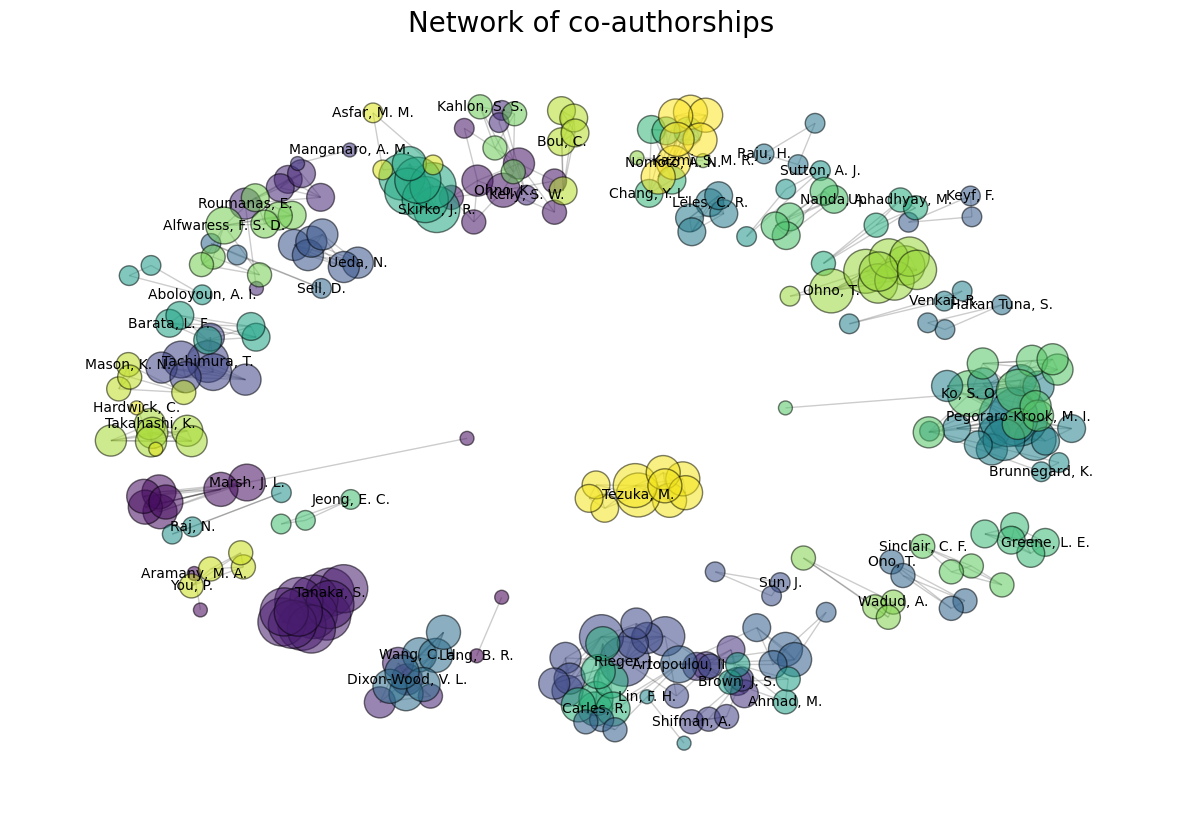

In [56]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from itertools import combinations

# Assume 'data' is a DataFrame obtained from 'parse_text_file'
# and contains an 'Authors' column with a list of authors for each row.

# Initialize an empty graph
H = nx.Graph()

# Add weighted edges based on co-authorship
for _, row in data.iterrows():
    authors = row['Authors']
    for author1, author2 in combinations(authors, 2):
        if H.has_edge(author1, author2):
            H[author1][author2]['weight'] += 1
        else:
            H.add_edge(author1, author2, weight=1)

# Calculate the average weight (collaborations) across all edges
all_weights = [data['weight'] for u, v, data in H.edges(data=True)]
average_weight = sum(all_weights) / len(H.edges())

# Find nodes with degree higher than average (hotspots)
hotspots = {node for node, degree in H.degree(weight='weight') if degree / (len(H) - 1) > average_weight}

# Detect communities using the Louvain method
partition = community_louvain.best_partition(H, weight='weight')

# Create a color map for the communities
community_colors = [partition[node] for node in H.nodes()]

# Correct the node_sizes calculation
node_sizes = [sum(data['weight'] for _, _, data in H.edges(node, data=True)) * 100 for node in H.nodes()]

# Visualization
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(H, k=0.2)

# Draw nodes, color-coded by community and sized by weight (hotspots are larger)
nx.draw_networkx_nodes(H, pos, node_color=community_colors, node_size=node_sizes, alpha=0.1)

# Draw edges
nx.draw_networkx_edges(H, pos, alpha=0.2)

# Highlight hotspots with a distinct node border color
hotspot_colors = ['orange' if node in hotspots else 'black' for node in H.nodes()]
nx.draw_networkx_nodes(H, pos, node_color=community_colors, node_size=node_sizes, edgecolors=hotspot_colors, alpha=0.5)


for community, (representative, _) in community_representatives.items():
    nx.draw_networkx_labels(G, pos, labels={representative: representative}, font_size=10)

# Turn off the axis for a clean look
plt.axis('off')


plt.title("Network of co-authorships", fontsize=20)
# Show the plot
plt.show()


In [57]:
# Calculate the total collaboration weight for each author
total_collab_weights = {node: sum(data['weight'] for _, _, data in H.edges(node, data=True)) for node in H.nodes()}

# Sort authors by their total collaboration weight
sorted_authors_by_weight = sorted(total_collab_weights.items(), key=lambda x: x[1], reverse=True)

# Optionally, you can select the top N authors
top_n_authors = sorted_authors_by_weight[:10]  # for example, top 10 authors

# List of influential authors
influential_authors = [author for author, weight in top_n_authors]
influential_authors


['Pegoraro-Krook, M. I.',
 'Aferri, H. C.',
 'Rieger, J.',
 'Tanaka, S.',
 'Hashizume, A.',
 'Hijikata, Y.',
 'Yamada, S.',
 'Ito, D.',
 'Nakayama, A.',
 'Kurita, K.']

In [60]:
# Initialize a dictionary to hold the most influential author for each community
community_influential_authors = {}

# Iterate through each community
for community in set(partition.values()):
    # Filter authors in the current community
    authors_in_community = [node for node in H.nodes() if partition[node] == community]

    # Calculate total collaboration weight for each author in the community
    author_weights = {
        author: sum(data['weight'] for _, _, data in H.edges(author, data=True))
        for author in authors_in_community
    }

    # Find the author with the highest total collaboration weight in the community
    most_influential_author = max(author_weights, key=author_weights.get)
    most_influential_weight = author_weights[most_influential_author]

    # Add the most influential author and their weight to the dictionary
    community_influential_authors[community] = (most_influential_author, most_influential_weight)

# Prepare the data for the report
report_data = [
    {
        'Community': community,
        'Influential Author': author,
        'Total Collaboration Weight': weight
    }
    for community, (author, weight) in community_influential_authors.items()
]


df_report_data_percomm = pd.DataFrame(report_data)
df_sorted = df_report_data_percomm.sort_values(by="Total Collaboration Weight", ascending=False)
df_sorted
excel_file_path = 'influential_authors.xlsx'
df_sorted.to_excel(excel_file_path, index=False)


In [59]:
# Calculate the total collaboration weight and degree for each author
author_info = {
    node: {
        'total_weight': sum(data['weight'] for _, _, data in H.edges(node, data=True)),
        'degree': H.degree(node),
        'community': partition[node]
    }
    for node in H.nodes()
}

# Sort authors by their total collaboration weight
sorted_authors = sorted(author_info.items(), key=lambda x: x[1]['total_weight'], reverse=True)

# Optionally, select the top N authors for the report
top_n_authors = 10  # Adjust as needed
top_authors_data = sorted_authors[:top_n_authors]

# Prepare the data for the report
report_data = [
    {
        'Author': author,
        'Total Collaboration Weight': info['total_weight'],
        'Degree': info['degree'],
        'Community': info['community']
    }
    for author, info in top_authors_data
]

report_data

df_report_data = pd.DataFrame(report_data)
df_report_data

,Author,Total Collaboration Weight,Degree,Community
0,"Pegoraro-Krook, M. I.",18,13,24
1,"Aferri, H. C.",18,13,24
2,"Rieger, J.",13,11,12
3,"Tanaka, S.",12,12,4
4,"Hashizume, A.",12,12,4
5,"Hijikata, Y.",12,12,4
6,"Yamada, S.",12,12,4
7,"Ito, D.",12,12,4
8,"Nakayama, A.",12,12,4
9,"Kurita, K.",12,12,4
